# Project - ECG Arrhythmia Classification
### Natalia Kolińska, Alicja Smaruj, Dorota Woźna, Kacper Zielak


#### Imports

In [1]:
#pip install -r requirements.txt

In [2]:
#Załadowanie pakietów
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.model_selection import StratifiedKFold
from sklearn.dummy import DummyClassifier
import numpy as np
from scikit_posthocs import posthoc_dunn
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
# import missingno as msno
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

#### Load data
Source: [Kaggle](https://www.kaggle.com/datasets/sadmansakib7/ecg-arrhythmia-classification-dataset?select=Sudden+Cardiac+Death+Holter+Database.csv)

In [3]:
df_1 = pd.read_csv("data/INCART 2-lead Arrhythmia Database.csv")
df_2 = pd.read_csv("data/MIT-BIH Arrhythmia Database.csv")
df_3 = pd.read_csv("data/MIT-BIH Supraventricular Arrhythmia Database.csv")
df_4= pd.read_csv("data/Sudden Cardiac Death Holter Database.csv")

c:\users\alicj\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
all_data = pd.concat([df_1, df_2, df_3, df_4])
all_data.head()

,record,type,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,...,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4
0,I01,N,163.0,165.0,0.069610,-0.083281,0.614133,-0.392761,0.047159,15.0,...,-0.023370,14.0,3.0,23.0,6.0,-0.023370,-0.011650,0.082608,0.101373,-0.183387
1,I01,N,165.0,166.0,-0.097030,0.597254,-0.078704,-0.078704,-0.137781,3.0,...,0.081637,15.0,5.0,27.0,7.0,0.081637,0.102992,0.191225,0.217544,-0.068248
2,I01,N,166.0,102.0,0.109399,0.680528,-0.010649,-0.010649,-0.720620,6.0,...,-0.148539,33.0,13.0,52.0,6.0,-0.148539,-0.060620,0.081080,0.204400,0.335172
3,I01,VEB,102.0,231.0,0.176376,0.256431,-0.101098,-0.707525,-0.101098,4.0,...,0.046898,21.0,9.0,34.0,4.0,0.046898,0.083728,0.279512,0.526785,0.450969
4,I01,N,231.0,165.0,0.585577,0.607461,-0.083499,-0.083499,-0.167858,3.0,...,-0.112552,32.0,5.0,43.0,6.0,-0.112552,0.012989,0.091491,0.134004,0.265232


In [5]:
all_data.shape

(963654, 34)

#### Explore data

Dependent variable
- N (Normal),
- SVEB (Supraventricular ectopic beat),
- VEB (Ventricular ectopic beat),
- F (Fusion beat),
- Q (Unknown beat).

In [6]:
all_data.groupby("type").size()

type
F         1256
N       809352
Q         6620
SVEB     18540
VEB      51669
dtype: int64

Zbiór danych zawiera cechy utworzone na podstawie wynikow EKG serca. Podawane są wysokości lub szerokości wyliczone między specyficznymi momentami w szeregu czasowym. Pozwala to na zastosowanie uczenia maszynowego do klasyfikacji szeregów czasowych.

<img src="images/wykres_ecg.png" alt="Wykres" width="400"/>
<img src="images/prepost.png" alt="Wykres2" width="400"/>

Autorzy zbioru utworzyli 16 zmiennych. Zbadali je na surowych szeregach czasowych (a) oraz przetworzonych szeregach na których usunięto szum (b).Stąd 32 kolumny z pomiarami. Surowe dane mają przedrostek '0' a przetworzone '1'.

<img src="images/LeadAB.png" alt="Wykres2" width="800"/>

Check if anything is null

In [7]:
all_data.isnull().any()

record            True
type              True
0_pre-RR          True
0_post-RR         True
0_pPeak           True
0_tPeak           True
0_rPeak           True
0_sPeak           True
0_qPeak           True
0_qrs_interval    True
0_pq_interval     True
0_qt_interval     True
0_st_interval     True
0_qrs_morph0      True
0_qrs_morph1      True
0_qrs_morph2      True
0_qrs_morph3      True
0_qrs_morph4      True
1_pre-RR          True
1_post-RR         True
1_pPeak           True
1_tPeak           True
1_rPeak           True
1_sPeak           True
1_qPeak           True
1_qrs_interval    True
1_pq_interval     True
1_qt_interval     True
1_st_interval     True
1_qrs_morph0      True
1_qrs_morph1      True
1_qrs_morph2      True
1_qrs_morph3      True
1_qrs_morph4      True
dtype: bool

Check how many percentage are null values in test_data

In [8]:
round(all_data.isnull().sum() * 100 / len(all_data), 2)

record             7.91
type               7.91
0_pre-RR           7.91
0_post-RR          7.91
0_pPeak            7.91
0_tPeak            7.91
0_rPeak            7.91
0_sPeak            7.91
0_qPeak            7.91
0_qrs_interval     7.91
0_pq_interval      7.91
0_qt_interval      7.91
0_st_interval      7.91
0_qrs_morph0       7.91
0_qrs_morph1       7.91
0_qrs_morph2       7.91
0_qrs_morph3       7.91
0_qrs_morph4       7.91
1_pre-RR          18.12
1_post-RR         18.12
1_pPeak           18.12
1_tPeak           18.12
1_rPeak           18.12
1_sPeak           18.12
1_qPeak           18.12
1_qrs_interval    18.12
1_pq_interval     18.12
1_qt_interval     18.12
1_st_interval     18.12
1_qrs_morph0      18.12
1_qrs_morph1      18.12
1_qrs_morph2      18.12
1_qrs_morph3      18.12
1_qrs_morph4      18.12
dtype: float64

<AxesSubplot:>

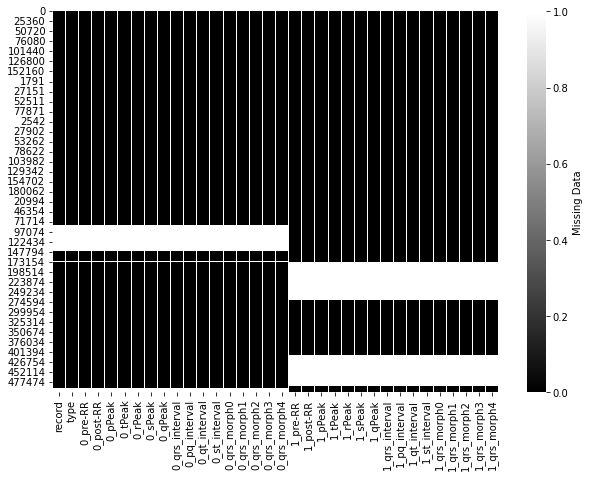

In [9]:
plt.figure(figsize=(10,7))
sns.heatmap(all_data.isna(),
            cmap="binary_r",
            cbar_kws={'label': 'Missing Data'})


Remove null observations from test_data

In [10]:
all_data = all_data.dropna()

Remove 'record' column, because the name of the subject/patient is irrelevant in this study.

In [11]:
all_data = all_data.drop("record", axis=1)

#### Train-test split

In [12]:
train_data, test_data = train_test_split(all_data, test_size=0.2, stratify=all_data['type'])

In [13]:
test_data.groupby("type").size()

type
F          251
N       128943
Q           29
SVEB      3700
VEB       9642
dtype: int64

Split X and y

In [14]:
y_train = train_data["type"]
X_train = train_data.drop(columns=["type"])

In [15]:
y_test = test_data["type"]
X_test = test_data.drop(columns=["type"])

#### Outliers

Check if outliers influence arrhythmia

In [16]:
print(
    "Q1:",
    train_data["0_pPeak"].quantile(0.25),
    "Q2:",
    train_data["0_pPeak"].quantile(0.5),
    "Q3:",
    train_data["0_pPeak"].quantile(0.75),
)
print("Min:", min(train_data["0_pPeak"]), "Max:", max(train_data["0_pPeak"]))

Q1: -0.0330697520417744 Q2: 0.0149675703762112 Q3: 0.0751984718279349
Min: -4.208600735 Max: 10.56590393


In [17]:
q3 = train_data["0_pPeak"].quantile(0.75)
print("Amount of outliers:", len(train_data.loc[train_data["0_pPeak"] > q3]))
print("Percentage of type in the outlier group")
train_data.loc[train_data["0_pPeak"] > q3].groupby("type").size() * 100 / len(train_data.loc[train_data["0_pPeak"] > q3])

Amount of outliers: 142564
Percentage of type in the outlier group


type
F        0.302320
N       78.994697
Q        0.062428
SVEB     3.337448
VEB     17.303106
dtype: float64

In [18]:
#Jest bardzo dużo outlierów, ale czy powinniśmy je usunąć lub zastąpić? Możliwe, że to były mocniejsze uderzenia serca u zdrowych osób.

#### Visualisation

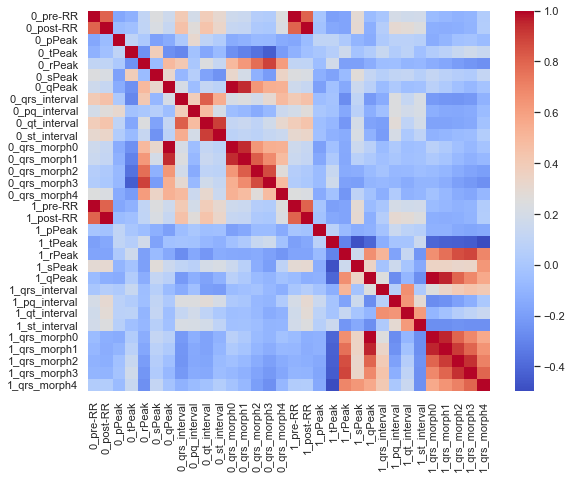

In [19]:
corr_matrix = X_train.corr()
plt.figure(figsize=(9,7))
sns.set_theme("notebook")
sns.set_palette("PuBuGn_d")
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.savefig("images/corplot.png")

In [20]:
train_data0 = train_data[["type", *[column_name for column_name in train_data.columns if column_name.startswith("0_")]]]

In [21]:
train_data1 = train_data[["type", *[column_name for column_name in train_data.columns if column_name.startswith("1_")]]]

Wykresy pudełkowe dla danych surowych (0) i przefiltrowanych (1) podzielone na grupy:
* pre-RR i post-RR
* peaks
* intervals
* morphology

In [21]:
# Zbudowanie wykresów pudełkowych trwa ok. 3 minuty.
# Jeśli nie potrzebujesz wersji interaktywnej, możesz skorztstać z zapisanych obrazów. 

prepost_0=["0_pre-RR", "0_post-RR"]
data_to_box_0 = pd.melt(train_data0[["type", *prepost_0]], id_vars="type", value_vars=prepost_0)
fig1 = px.box(data_to_box_0, y="value", x="variable", color="type", width=1000)
fig1.write_image("images/box_RR_0.png")

prepost_1=["1_pre-RR", "1_post-RR"]
data_to_box_1 = pd.melt(train_data1[["type", *prepost_1]], id_vars="type", value_vars=prepost_1)
fig2 = px.box(data_to_box_1, y="value", x="variable", color="type", width=1000)
fig2.write_image("images/box_RR_1.png")

peaks_0=["0_pPeak", "0_tPeak", "0_rPeak", "0_sPeak", "0_qPeak"]
data_to_box_3 = pd.melt(train_data0[["type",*peaks_0]], id_vars="type", value_vars=peaks_0)
fig3= px.box(data_to_box_3, y="value", x="variable", color="type", width=1000)
fig3.write_image("images/box_peaks_0.png")

peaks_1=["1_pPeak", "1_tPeak", "1_rPeak", "1_sPeak", "1_qPeak"]
data_to_box4 = pd.melt(train_data1[["type", *peaks_1]], id_vars="type", value_vars=peaks_1)
fig4= px.box(data_to_box4, y="value", x="variable", color="type", width=1000)
fig4.write_image("images/box_peaks_1.png")

intervals_0=["0_qrs_interval", "0_pq_interval", "0_qt_interval", "0_st_interval"]
data_to_box5 = pd.melt(train_data0[["type", *intervals_0]], id_vars="type", value_vars=intervals_0)
fig5 = px.box(data_to_box5, y="value", x="variable", color="type", width=1000)
fig5.write_image("images/box_intervals_0.png")

intervals_1=["1_qrs_interval", "1_pq_interval", "1_qt_interval", "1_st_interval"]
data_to_box6 = pd.melt(train_data1[["type", *intervals_1]], id_vars="type", value_vars=intervals_1)
fig6 = px.box(data_to_box6, y="value", x="variable", color="type", width=1000)
fig6.write_image("images/box_intervals_1.png")

morphs_0=["0_qrs_morph0", "0_qrs_morph1", "0_qrs_morph2", "0_qrs_morph3", "0_qrs_morph4",]
data_to_box7 = pd.melt(train_data0[["type", *morphs_0]], id_vars="type", value_vars=morphs_0)
fig7 = px.box(data_to_box7, y="value", x="variable", color="type")
fig7.write_image("images/box_morphs_0.png")

morphs_1=["1_qrs_morph0", "1_qrs_morph1", "1_qrs_morph2", "1_qrs_morph3", "1_qrs_morph4",]
data_to_box8 = pd.melt(train_data1[["type", *morphs_1]], id_vars="type", value_vars=morphs_1)
fig8 = px.box(data_to_box8, y="value", x="variable", color="type")
fig8.write_image("images/box_morphs_1.png")

#### Standarization

In [22]:
std_all = StandardScaler()
train_data_std = std_all.fit_transform(X_train)
train_data_std = pd.DataFrame(train_data_std, columns=X_train.columns)

test_data_std = std_all.transform(X_test)
test_data_std = pd.DataFrame(test_data_std, columns=X_test.columns)

#### PCA

In [23]:
pca = PCA(n_components=2)
components = pca.fit_transform(train_data_std)

fig = px.scatter(components, x=0, y=1, color=y_train, width=800)
fig.write_image("images/pca_2d.png")
# fig.show()

#### Dummy model

Stworzono "głupi" model, który będzie służył do porównań, czy nasze modele uzyskują lepsze wyniki. Przyjęto strategię most-frequent, co będzie skutkowało zaklysyfikowaniem wszystkich obserwacji jako N (normalne).

In [24]:
dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(X_train, y_train)
y_pred = dummy_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print("Balanced accuracy:", balanced_accuracy)

precision = precision_score(y_test, y_pred, average="weighted")
print("Precision:", precision)

recall = recall_score(y_test, y_pred, average="weighted")
print("Sensitivity (recall):", recall)

# specificity = specificity_score(y_test, y_pred)
# print("Specificity :", specificity, average="weighted")

f1 = f1_score(y_test, y_pred, average="weighted")
print("F1-Score:", f1)

Accuracy: 0.9044506014800267
Balanced accuracy: 0.2


c:\users\alicj\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Precision: 0.818030890517582
Sensitivity (recall): 0.9044506014800267
F1-Score: 0.8590728369450557


#### New variables and its significance

In [25]:
# Na podstawie wykresów pudełkowych box_RR_0 i box_RR_1 można zauważyć, że w przypadku zaburzenia SVEB, preRR jest często krótsze niż postRR,
# dlatego dodano dwie zmienne opisujące ich różnice.
data_new=pd.DataFrame()
data_new["0_RR_diff"] = X_train["0_pre-RR"] - X_train["0_post-RR"]
data_new["1_RR_diff"] = X_train["1_pre-RR"] - X_train["1_post-RR"]
data_new["type"] =  y_train

def perform_dunn_test(data, column, group="type", p_adjust="fdr_bh"):
    dunn_df = posthoc_dunn(data, val_col=column, group_col=group, p_adjust=p_adjust)
    remove = np.tril(np.ones(dunn_df.shape), k=0).astype(bool)
    dunn_df[remove] = np.nan
    molten_df = dunn_df.melt(ignore_index=False).reset_index().dropna()
    molten_df.rename(columns={"value": f"{column}_sign"}, inplace=True)
    return molten_df

molten_df1 = perform_dunn_test(data_new, "0_RR_diff")
molten_df2 = perform_dunn_test(data_new, "1_RR_diff")

dunn_summ = pd.merge(molten_df1, molten_df2)

# wskazanie istotnych
def color_red(val):
    color = "red" if val <= 0.05 else "black"
    return f"color: {color}"

# Stworzenie obiektu Styler i zastosowanie funkcji do kolumny "0_RR_diff"
dunn_summ = dunn_summ.style.applymap(color_red, subset=["0_RR_diff_sign",	"1_RR_diff_sign"])
dunn_summ

,index,variable,0_RR_diff_sign,1_RR_diff_sign
0,F,N,0.071322,0.071322
1,F,Q,0.011008,0.011008
2,N,Q,0.001088,0.001088
3,F,SVEB,0.000000,0.000000
4,N,SVEB,0.000000,0.000000
5,Q,SVEB,0.000000,0.000000
6,F,VEB,0.000000,0.000000
7,N,VEB,0.000000,0.000000
8,Q,VEB,0.000000,0.000000
9,SVEB,VEB,0.000000,0.000000


Powyższe wyniki potwierdzają, że nowo utworzone zmienne istotnie różnicują wszystkie pary typów poza F i N. Następnie przeprowadzimy standaryzację dla nowych zmiennych.

#### Pre-processing (dla wszystkich)

X_train - całe dane treningowe oryginalne

y_train - etykiety treningowe dla całego zbioru

X_sample - próbka danych treningowych do grid-search

y_sample- etykiety treningowe dla próbki

In [26]:
X_train["0_RR_diff"] = X_train["0_pre-RR"] - X_train["0_post-RR"]
X_train["1_RR_diff"] = X_train["1_pre-RR"] - X_train["1_post-RR"]

X_test["0_RR_diff"] = X_test["0_pre-RR"] - X_test["0_post-RR"]
X_test["1_RR_diff"] = X_test["1_pre-RR"] - X_test["1_post-RR"]

In [27]:
X_train.shape

(570257, 34)

Sampling for grid-search

In [28]:
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, test_size=0.90, stratify=y_train, random_state=42)

In [29]:
y_sample.value_counts()

N       51576
VEB      3857
SVEB     1480
F         100
Q          12
Name: type, dtype: int64

In [30]:
pipe_resample = Pipeline([
    ('oversampler_F', RandomOverSampler(sampling_strategy={'F': 200})),
    ('undersampler_N', RandomUnderSampler(sampling_strategy={'N': 5000})),
    ('oversampler_Q', RandomOverSampler(sampling_strategy={'Q': 100}))
])

X_resampled, y_resampled = pipe_resample.fit_resample(X_sample, y_sample)
y_resampled.value_counts()

N       5000
VEB     3857
SVEB    1480
F        200
Q        100
Name: type, dtype: int64

In [53]:
#ostatecznie z tego nie korzystam, ale szostawiam jakbyście potrzebowali
pipeline= Pipeline(
    [
        ('std_scaler', StandardScaler())
    ]
)
X_train_std = pd.DataFrame(pipeline.fit_transform(X_train), columns=X_train.columns)
X_test_std = pd.DataFrame(pipeline.transform(X_test), columns=X_train.columns)
X_sample_std= pd.DataFrame(pipeline.fit_transform(X_resampled), columns=X_train.columns)

#### Bardzo ważna komórka - wybór danych

In [32]:
#Komórka w której zmieniam, na jakich danych chcę testować algorytm
X_data_sample= X_resampled #X_sample #lub X_resampled
y_data_sample= y_resampled #y_sample #lub y_resampled 

# X_data_sample=X_train

X_data_train=X_train #lub X_train_std
y_data_train=y_train

X_data_test=X_test #X_test_std
y_data_test=y_test

#### Model 1 -Decision trees

##### KROK 1: Wizualizacja zależności między max_depth a accuracy

Sprawdzimy na wykresie w jakim przedziale warto szukać optymalnej głębokości drzewa

In [75]:
# drzewo decyzyjne z walidacją krzyżową i zbalansowaniem klas przy podziale na treningowe i testowe

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

ma_train = []
ma_test = []
for j in range(1, 31):
    model = tree.DecisionTreeClassifier(random_state=10, max_depth=j)
    a_test = []
    a_tren = []

    for i, (train_index, test_index) in enumerate(skf.split(X_data_sample, y_data_sample)):
        model.fit(X_data_sample.iloc[train_index], y_data_sample.iloc[train_index])
        a_test.append(model.score(X_data_sample.iloc[test_index], y_data_sample.iloc[test_index]).round(4))
        a_tren.append(model.score(X_data_sample.iloc[train_index], y_data_sample.iloc[train_index]).round(4))

    ma_test.append(np.mean(a_test))
    ma_train.append(np.mean(a_tren))

optimal_depth_tree=np.argmax(ma_test)+1
optimal_depth_tree

15

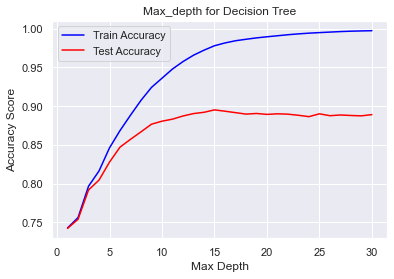

In [76]:
depths = np.arange(1, 31)
plt.plot(depths, ma_train, label="Train Accuracy", color="blue")
plt.plot(depths, ma_test, label="Test Accuracy", color="red")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.title("Max_depth for Decision Tree")
plt.legend()
plt.grid(True)
plt.savefig("images/grid_search_trees.png")
plt.show()

##### KROK 2: GridSearch for decision trees

In [77]:
model_dt= tree.DecisionTreeClassifier(random_state=42)

model_dt.fit(X_data_sample, y_data_sample)

trees_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(10,23,2),
    'min_samples_leaf': [1,2,4]
}
 
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
dt_grid_search = GridSearchCV(model_dt, trees_param_grid, cv=cv_strategy, scoring='balanced_accuracy', return_train_score=True)
dt_grid_search.fit(X_data_sample, y_data_sample)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(10, 23, 2),
                         'min_samples_leaf': [1, 2, 4]},
             return_train_score=True, scoring='balanced_accuracy')

In [78]:
tree_results=dt_grid_search.cv_results_

In [79]:
results_df = pd.DataFrame(tree_results)
params_df = pd.json_normalize(results_df['params'])
metrics = ['mean_test_score', 'std_test_score']
tree_results_df = pd.concat([params_df, results_df[metrics]], axis=1)

tree_results_df.columns=["criterion", "max_depth", "min_samples_leaf", "mean_test_score", "std_test_score"]
tree_results_df.sort_values(by='mean_test_score', ascending=False).head(10)

,criterion,max_depth,min_samples_leaf,mean_test_score,std_test_score
30,entropy,16,1,0.885150,0.011734
33,entropy,18,1,0.884613,0.012129
36,entropy,20,1,0.884120,0.011382
39,entropy,22,1,0.882397,0.010744
27,entropy,14,1,0.878022,0.011851
40,entropy,22,2,0.877159,0.014566
37,entropy,20,2,0.877102,0.014498
31,entropy,16,2,0.876589,0.009564
34,entropy,18,2,0.875902,0.013276
28,entropy,14,2,0.871779,0.011448


In [80]:
print(len(tree_results_df))

42


In [81]:
y_train.value_counts()

N       515768
VEB      38570
SVEB     14801
F         1004
Q          114
Name: type, dtype: int64

##### KROK 3: Zbudowanie modelu na wszystkich danych treningowych

In [82]:
best_dt_model = dt_grid_search.best_estimator_
best_dt_model
best_dt_model.fit(X_data_train, y_data_train)

DecisionTreeClassifier(criterion='entropy', max_depth=16, random_state=42)

##### KROK 4: Ocena dokładności

In [83]:
y_pred = best_dt_model.predict(X_data_test)
accuracy = accuracy_score(y_data_test, y_pred)
print("Accuracy:", accuracy)

balanced_accuracy = balanced_accuracy_score(y_data_test, y_pred)
print("Balanced accuracy:", balanced_accuracy)

precision = precision_score(y_data_test, y_pred, average="weighted")
print("Precision:", precision)

recall = recall_score(y_data_test, y_pred, average="weighted")
print("Sensivity (recall):", recall)

f1 = f1_score(y_data_test, y_pred, average="weighted")
print("F1-Score:", f1)

Accuracy: 0.9793988706905622
Balanced accuracy: 0.6741941030647417
Precision: 0.9791728344319431
Sensivity (recall): 0.9793988706905622
F1-Score: 0.9792565896531501


ROC-AUC curve

In [40]:
def our_roc_curves(X_test, y_test, best_model, title):
    class_labels = ['F', 'N', 'Q', 'SVEB', 'VEB']  
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

    y_pred_proba = best_model.predict_proba(X_test)
    
    fpr_dict = {}
    tpr_dict = {}
    roc_auc_dict = {}

    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

    for i, class_label in enumerate(class_labels):
        y_test_bin_i = y_test_bin[:, i]
        y_pred_prob_i = y_pred_proba[:, i]

        fpr, tpr, _ = roc_curve(y_test_bin_i, y_pred_prob_i)
        roc_auc = auc(fpr, tpr)

        fpr_dict[class_label] = fpr
        tpr_dict[class_label] = tpr
        roc_auc_dict[class_label] = roc_auc

        # Przypisanie koloru z listy dostępnych kolorów
        color = colors[i % len(colors)]

        # Ustaw etykiety na legendzie zamiast oryginalnych klas
        plt.plot(fpr, tpr, lw=2, label=f' {class_label} (AUC = {roc_auc:.2f})', color=color)

    plt.plot([0, 1], [0, 1], linestyle='--', color='black', lw=0.8)
    plt.title(title)
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.legend(loc="lower right")
    plt.show()

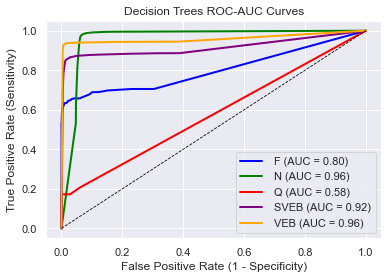

In [109]:
our_roc_curves(X_data_test, y_data_test, best_dt_model, "Decision Trees ROC-AUC Curves")

Confusion matrix

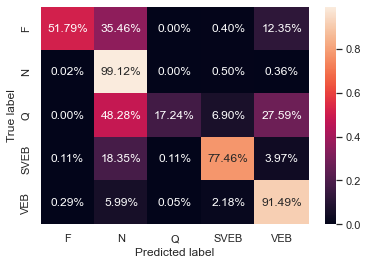

In [86]:
types=np.unique(y_test.values)
conf_matrix=pd.DataFrame(confusion_matrix(y_test, y_pred, labels=types), columns=types, index=types)
percentage=conf_matrix.div(conf_matrix.sum(axis=1), axis=0)
percentage = percentage.fillna(0)
plt.figure(figsize=(6, 4))
sns.heatmap(percentage, fmt='.2%', annot=True, annot_kws={"size": 12})
plt.xlabel("Predicted label");
plt.ylabel("True label");

Zmienne istotne

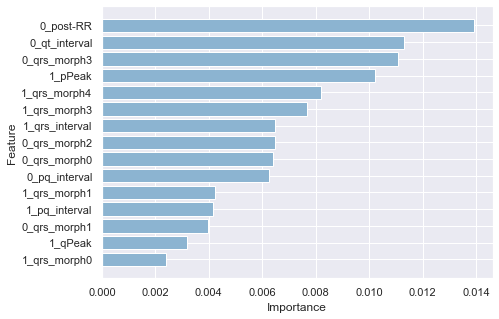

In [87]:
model=best_dt_model

indeksy = np.where(model.feature_importances_!=0)[0]
variables= [X_train.columns[i] for i in indeksy]
importances = model.feature_importances_[indeksy]

# sortowanie
importances, variables= zip(*sorted(zip(importances, variables), reverse=False))

# Tworzenie wykresu słupkowego z niezerowymi wartościami
fig, ax = plt.subplots(figsize=(7, 5))
plt.barh(variables[:15], importances[:15])

plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

#### Model 2 - Random Forest

##### KROK1: Wizualizacja zależności między głębokością drzewa i liczbą drzew a dokładnością

Wizualizacja pozwoli poznać przedziały w których warto szukać optymalnych estymatorów.

In [88]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

ma_train_rf = []
ma_test_rf = []
for j in range(1, 31):
    model = RFmodel = RandomForestClassifier(random_state=10, max_depth=j, n_estimators=10)
    a_test = []
    a_tren = []

    for i, (train_index, test_index) in enumerate(skf.split(X_data_sample, y_data_sample)):
        model.fit(X_data_sample.iloc[train_index], y_data_sample.iloc[train_index])
        a_test.append(model.score(X_data_sample.iloc[test_index], y_data_sample.iloc[test_index]).round(4))
        a_tren.append(model.score(X_data_sample.iloc[train_index], y_data_sample.iloc[train_index]).round(4))

    ma_test_rf.append(np.mean(a_test))
    ma_train_rf.append(np.mean(a_tren))

Optymalna głębokość: 30


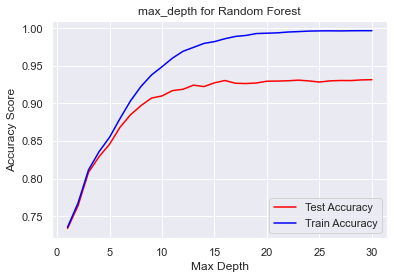

In [89]:
# Indeks głębokości drzewa, która daje najlepszą średnią dokładność testu
optimal_depth = np.argmax(ma_test_rf) + 1
print("Optymalna głębokość:", optimal_depth)

depths = range(1, 31)  
plt.plot(depths, ma_test_rf, label="Test Accuracy", color="red")
plt.plot(depths, ma_train_rf, label="Train Accuracy", color="blue")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.title("max_depth for Random Forest")
plt.legend()
plt.show()


##### Wizualizacja liczby drzew a dokładność

In [90]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
n_estimators_values = [1,2,3,4,5, 10, 15, 20]
ma_rf_train = []
ma_rf_test = []

for n_estimators in n_estimators_values:
    model = RandomForestClassifier(random_state=10, n_estimators=n_estimators, max_depth=18)
    a_test = []
    a_tren = []
    for i, (train_index, test_index) in enumerate(skf.split(X_data_sample, y_data_sample)):
        model.fit(X_data_sample.iloc[train_index], y_data_sample.iloc[train_index])
        a_test.append(model.score(X_data_sample.iloc[test_index], y_data_sample.iloc[test_index]).round(4))
        a_tren.append(model.score(X_data_sample.iloc[train_index], y_data_sample.iloc[train_index]).round(4))

    ma_rf_test.append(np.mean(a_test))
    ma_rf_train.append(np.mean(a_tren))

optimal_n_estimators = n_estimators_values[np.argmax(ma_rf_test)]
print("Optymalna wartość n_estimators:", optimal_n_estimators)


Optymalna wartość n_estimators: 15


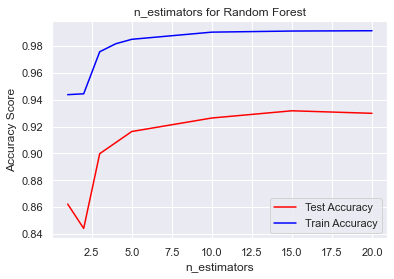

In [91]:
plt.plot(n_estimators_values, ma_rf_test, label="Test Accuracy", color="red")
plt.plot(n_estimators_values, ma_rf_train, label="Train Accuracy", color="blue")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy Score")
plt.title("n_estimators for Random Forest")
plt.legend()
plt.show()

##### GridSearchCV dla RandomForest

In [92]:
model_rf=RandomForestClassifier(random_state=42)

rf_param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=15, stop=50, num=10)],
    'max_depth': [int(x) for x in np.linspace(15, 35, num=10)],
    'min_samples_leaf': [1, 2, 4]
}

model_rf.fit(X_data_sample, y_data_sample)

rf_grid_search = RandomizedSearchCV(
    model_rf,
    param_distributions=rf_param_dist,
    n_iter=10,
    cv=5, 
    scoring='balanced_accuracy', 
    random_state=42
)

rf_grid_search.fit(X_data_sample, y_data_sample)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'max_depth': [15, 17, 19, 21, 23, 26,
                                                      28, 30, 32, 35],
                                        'min_samples_leaf': [1, 2, 4],
                                        'n_estimators': [15, 18, 22, 26, 30, 34,
                                                         38, 42, 46, 50]},
                   random_state=42, scoring='balanced_accuracy')

In [93]:
rf_results=rf_grid_search.cv_results_

In [94]:
results_df = pd.DataFrame(rf_results)
params_df = pd.json_normalize(results_df['params'])
metrics = ['mean_test_score', 'std_test_score']
rf_results_df = pd.concat([params_df, results_df[metrics]], axis=1)
rf_results_df.sort_values(by='mean_test_score', ascending=False).head(10)

,n_estimators,min_samples_leaf,max_depth,mean_test_score,std_test_score
2,22,1,26,0.921441,0.022833
5,38,2,30,0.900700,0.024260
6,38,2,28,0.900289,0.024498
7,50,2,21,0.896655,0.026051
8,34,1,15,0.884180,0.011497
3,50,1,15,0.883173,0.016544
4,26,4,30,0.856363,0.029175
0,26,4,28,0.855407,0.028922
1,38,4,32,0.854359,0.031587
9,34,4,26,0.852673,0.032766


##### Zbudowanie modelu na wszystkich danych treningowych

In [95]:
best_rf_model = rf_grid_search.best_estimator_
best_rf_model.fit(X_data_train, y_data_train)

RandomForestClassifier(max_depth=26, n_estimators=22, random_state=42)

##### Ocena dokładności

In [96]:
y_pred = best_rf_model.predict(X_data_test)
accuracy = accuracy_score(y_data_test, y_pred)
print("Accuracy:", accuracy)

balanced_accuracy = balanced_accuracy_score(y_data_test, y_pred)
print("Balanced accuracy:", balanced_accuracy)

precision = precision_score(y_data_test, y_pred, average="weighted")
print("Precision:", precision)

recall = recall_score(y_data_test, y_pred, average="weighted")
print("Sensivity (recall):", recall)

f1 = f1_score(y_data_test, y_pred, average="weighted")
print("F1-Score:", f1)

Accuracy: 0.9856276084592993
Balanced accuracy: 0.6525630940510748
Precision: 0.98517379178044
Sensivity (recall): 0.9856276084592993
F1-Score: 0.9850493975417804


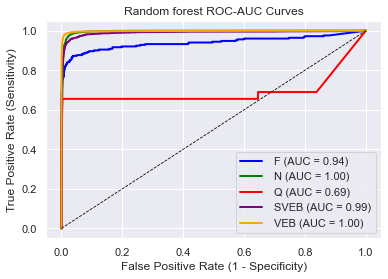

In [97]:
our_roc_curves(X_data_test, y_data_test, best_rf_model, "Random forest ROC-AUC Curves")

Confusion matrix

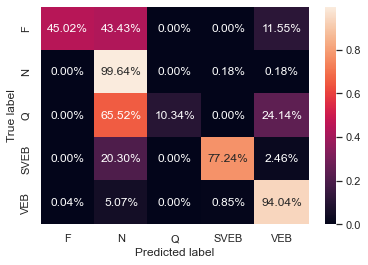

In [98]:
types=np.unique(y_data_test.values)
conf_matrix=pd.DataFrame(confusion_matrix(y_data_test, y_pred, labels=types), columns=types, index=types)
percentage=conf_matrix.div(conf_matrix.sum(axis=1), axis=0)
percentage = percentage.fillna(0)
plt.figure(figsize=(6, 4))
sns.heatmap(percentage, fmt='.2%', annot=True, annot_kws={"size": 12})
plt.xlabel("Predicted label");
plt.ylabel("True label");

Zmienne istotne

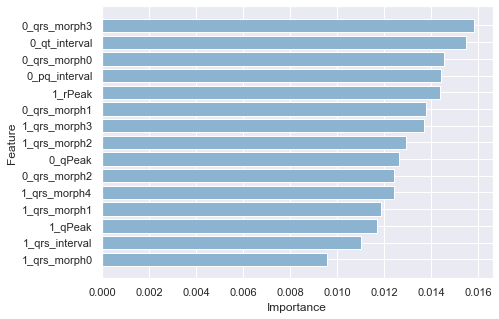

In [99]:
model=best_rf_model

indeksy = np.where(model.feature_importances_!=0)[0]
variables= [X_train.columns[i] for i in indeksy]
importances = model.feature_importances_[indeksy]

# sortowanie
importances, variables= zip(*sorted(zip(importances, variables), reverse=False))

# Tworzenie wykresu słupkowego z niezerowymi wartościami
fig, ax = plt.subplots(figsize=(7, 5))
plt.barh(variables[:15], importances[:15])

plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

#### Model 3 

In [34]:
from sklearn.svm import SVC
svc_clf = SVC(probability=True, kernel='rbf')

In [35]:
svc_clf.fit(X_data_sample, y_data_sample)

SVC(probability=True)

In [ ]:
# grid_svm = GridSearchCV(
#     probability=True
#     pipeline_svm,
#     param_grid=param_svm,
#     refit=True,
#     n_jobs=-1,
#     scoring='accuracy',
#     cv=StratifiedKFold(label_train, n_folds=5),)

In [36]:
y_pred = svc_clf.predict(X_data_test)
accuracy = accuracy_score(y_data_test, y_pred)
print("Accuracy:", accuracy)

balanced_accuracy = balanced_accuracy_score(y_data_test, y_pred)
print("Balanced accuracy:", balanced_accuracy)

precision = precision_score(y_data_test, y_pred, average="weighted")
print("Precision:", precision)

recall = recall_score(y_data_test, y_pred, average="weighted")
print("Sensivity (recall):", recall)

f1 = f1_score(y_data_test, y_pred, average="weighted")
print("F1-Score:", f1)

Accuracy: 0.9416827412057658
Balanced accuracy: 0.44897252824058287


c:\users\alicj\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Precision: 0.9461683295842072
Sensivity (recall): 0.9416827412057658
F1-Score: 0.9435491624496746


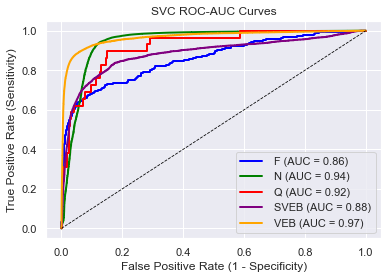

In [37]:
our_roc_curves(X_data_test, y_data_test, svc_clf, "SVC ROC-AUC Curves")

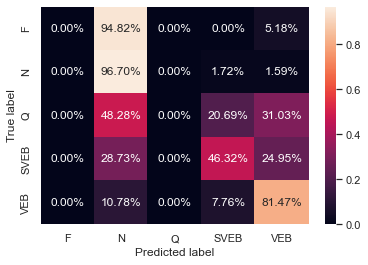

In [38]:
types=np.unique(y_test.values)
conf_matrix=pd.DataFrame(confusion_matrix(y_test, y_pred, labels=types), columns=types, index=types)
percentage=conf_matrix.div(conf_matrix.sum(axis=1), axis=0)
percentage = percentage.fillna(0)
plt.figure(figsize=(6, 4))
sns.heatmap(percentage, fmt='.2%', annot=True, annot_kws={"size": 12})
plt.xlabel("Predicted label");
plt.ylabel("True label");

In [122]:
model=svc_clf

indeksy = np.where(model.feature_importances_!=0)[0]
variables= [X_train.columns[i] for i in indeksy]
importances = model.feature_importances_[indeksy]

# sortowanie
importances, variables= zip(*sorted(zip(importances, variables), reverse=False))

# Tworzenie wykresu słupkowego z niezerowymi wartościami
fig, ax = plt.subplots(figsize=(7, 5))
plt.barh(variables[:15], importances[:15])

plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

AttributeError: 'SVC' object has no attribute 'feature_importances_'

In [ ]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_data_sample,y_data_sample)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  12.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  12.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  12.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  13.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  14.2s


In [ ]:
grid.best_params_

In [ ]:
print(grid.best_estimator_)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
grid_predictions = grid.predict(X_data_test)
print(confusion_matrix(y_data_test, grid_predictions))
print(classification_report(y_test,grid_predictions))

In [78]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_std, y_data_train)

KNeighborsClassifier(n_neighbors=3)

In [80]:
knn.fit(X_train_std, y_data_train)
y_pred = knn.predict(X_test_std.values)

c:\users\alicj\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names



In [81]:
accuracy = accuracy_score(y_data_test, y_pred)
print("Accuracy:", accuracy)

balanced_accuracy = balanced_accuracy_score(y_data_test, y_pred)
print("Balanced accuracy:", balanced_accuracy)

precision = precision_score(y_data_test, y_pred, average="weighted")
print("Precision:", precision)

recall = recall_score(y_data_test, y_pred, average="weighted")
print("Sensivity (recall):", recall)

f1 = f1_score(y_data_test, y_pred, average="weighted")
print("F1-Score:", f1)

Accuracy: 0.9865885736330796
Balanced accuracy: 0.7062789822059855
Precision: 0.9861571085800502
Sensivity (recall): 0.9865885736330796
F1-Score: 0.9862786990271036


c:\users\alicj\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names



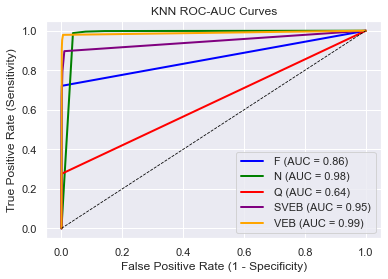

In [82]:
our_roc_curves(X_test_std.values, y_data_test, knn, "KNN ROC-AUC Curves")

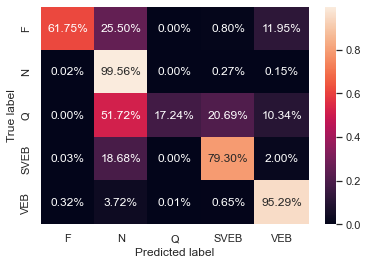

In [83]:
types=np.unique(y_test.values)
conf_matrix=pd.DataFrame(confusion_matrix(y_test, y_pred, labels=types), columns=types, index=types)
percentage=conf_matrix.div(conf_matrix.sum(axis=1), axis=0)
percentage = percentage.fillna(0)
plt.figure(figsize=(6, 4))
sns.heatmap(percentage, fmt='.2%', annot=True, annot_kws={"size": 12})
plt.xlabel("Predicted label");
plt.ylabel("True label");

In [62]:
from sklearn.model_selection import cross_val_score

k_values = [i for i in range (1,31)]
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_sample_std.values, y_data_sample, cv=5)
    scores.append(np.mean(score))

[0.9326881201593545, 0.9173641084375254, 0.9255433188047693, 0.9176467703108264, 0.9182106800852626, 0.9114417743936711, 0.9107840122167195, 0.9056132043790719, 0.9043908696282313, 0.9001604858408363, 0.899784280871431, 0.8976218755633795, 0.8952717212636669, 0.890664999946976, 0.8893488127936202, 0.8866222767779817, 0.8850243998571887, 0.8861527496456233, 0.8833324496007297, 0.8826741571842159, 0.8797596512437652, 0.878161420829931, 0.8761874714996235, 0.8749648716290019, 0.8718631911230826, 0.8703587689251338, 0.8681964519903426, 0.8668803090236169, 0.8653762845053394, 0.8621797794910406]


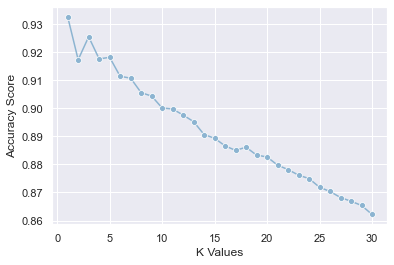

In [63]:
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")
print(scores)

In [57]:
y_pred = knn.predict(X_test_std.values)

c:\users\alicj\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names



In [66]:
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)

In [69]:
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False)
grid.fit(X_sample_std.values, y_data_sample)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(n_neighbors=30),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             scoring='accuracy')

In [70]:
print(grid.best_estimator_)

KNeighborsClassifier(n_neighbors=1)


In [71]:
best = grid.best_estimator_
best.fit(X_train_std, y_data_train)

KNeighborsClassifier(n_neighbors=1)

In [73]:
y_pred = best.predict(X_test_std.values)

c:\users\alicj\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names



In [74]:
accuracy = accuracy_score(y_data_test, y_pred)
print("Accuracy:", accuracy)

balanced_accuracy = balanced_accuracy_score(y_data_test, y_pred)
print("Balanced accuracy:", balanced_accuracy)

precision = precision_score(y_data_test, y_pred, average="weighted")
print("Precision:", precision)

recall = recall_score(y_data_test, y_pred, average="weighted")
print("Sensivity (recall):", recall)

f1 = f1_score(y_data_test, y_pred, average="weighted")
print("F1-Score:", f1)

Accuracy: 0.9861115982183566
Balanced accuracy: 0.7324249044144101
Precision: 0.9858611325104061
Sensivity (recall): 0.9861115982183566
F1-Score: 0.9859703664458932


c:\users\alicj\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names



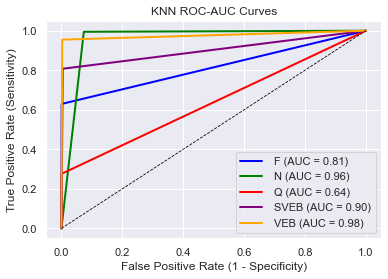

In [76]:
our_roc_curves(X_test_std.values, y_data_test, best, "KNN ROC-AUC Curves")

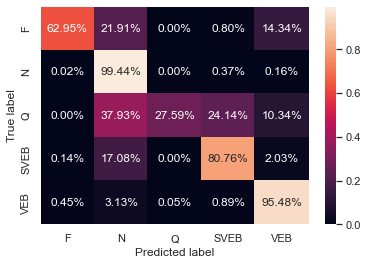

In [77]:
types=np.unique(y_test.values)
conf_matrix=pd.DataFrame(confusion_matrix(y_test, y_pred, labels=types), columns=types, index=types)
percentage=conf_matrix.div(conf_matrix.sum(axis=1), axis=0)
percentage = percentage.fillna(0)
plt.figure(figsize=(6, 4))
sns.heatmap(percentage, fmt='.2%', annot=True, annot_kws={"size": 12})
plt.xlabel("Predicted label");
plt.ylabel("True label");

#### Voting Classifier